In [52]:
import numpy as np                  
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt
import warnings
import ffn
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Download ticker data

In [30]:
symbols = ['GDX','GDXJ','GLD', 'AAPL','GOOGL', 'META','AMD',
           'NVDA','CSCO', 'ORCL', 'TTWO', 'EA', 'HYG', 
           'LQD', 'JNK', 'SLV', 'USLV', 'SIVR', 'USO', 'UWT', 
           'QQQ', 'SPY', 'VOO', 'VDE', 'VTI', 'EMLP', 'VDC', 
           'FSTA', 'KXI', 'IBB', 'VHT','VNQ', 'IYR', 'MSFT', 
           'PG', 'TMF', 'UPRO', 'WFC', 'JPM', 'GS', 'CVX', 
           'XOM', 'INTC', 'COST', 'WMT', 'T', 'VZ', 'CMCSA', 'AMZN']

In [31]:
def get_symbols(symbols, data_source, ohlc, begin_date=None, end_date=None):
    out = []
    new_symbols = []
    for symbol in symbols:
        df = yf.download(symbol, start=begin_date, end=end_date)
        #df = web.DataReader(symbol, data_source, begin_date, end_date)
        df = df[ohlc]
        new_symbols.append(symbol) 
        out.append(df.astype('float'))
        data = pd.concat(out, axis = 1)
        data.columns = new_symbols
        data = data.dropna(axis=1)
    return data.dropna(axis=1)

In [32]:
start = pd.Timestamp('2012-01-01')
end = pd.Timestamp('2023-12-31')
prices = get_symbols(symbols, data_source='yahoo', ohlc='Close', begin_date=start, end_date=end)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TWTR']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ATVI']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]

In [33]:
combo = prices.copy()
combo.index = pd.DatetimeIndex(combo.index)
combo.head()

,GDX,GDXJ,GLD,AAPL,GOOGL,AMD,NVDA,CSCO,ORCL,TTWO,EA,HYG,LQD,JNK,SLV,USLV,SIVR,USO,QQQ,SPY,VOO,VDE,VTI,VDC,KXI,IBB,VHT,VNQ,IYR,MSFT,PG,TMF,UPRO,WFC,JPM,GS,CVX,XOM,INTC,COST,WMT,T,VZ,CMCSA,AMZN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-03,53.799999,104.320000,155.919998,14.686786,16.651901,5.48,3.5100,18.629999,25.860001,14.00,21.299999,89.720001,113.669998,115.980003,28.830000,3333.000000,29.420000,317.519989,56.900002,127.500000,116.599998,103.540001,65.209999,81.489998,33.625000,35.106667,61.930000,58.490002,57.160000,26.770000,66.830002,170.925003,2.627500,28.430000,34.980000,95.360001,110.370003,86.000000,24.540001,84.599998,20.110001,22.945620,39.730000,12.250,8.9515
2012-01-04,53.740002,104.320000,156.710007,14.765714,16.723724,5.46,3.5500,18.990000,26.010000,14.00,20.290001,89.570000,113.760002,115.919998,28.389999,3180.000000,28.990000,318.160004,57.139999,127.699997,116.800003,103.849998,65.239998,81.269997,33.384998,34.956669,61.590000,57.490002,56.520000,27.400000,66.800003,165.149994,2.631667,28.559999,34.950001,94.739998,110.180000,86.019997,25.110001,84.070000,19.903334,22.983383,39.209999,12.365,8.8755
2012-01-05,53.900002,103.639999,157.779999,14.929643,16.491741,5.46,3.6775,18.920000,26.590000,14.66,20.530001,89.180000,113.269997,115.500000,28.510000,3221.000000,29.080000,313.359985,57.610001,128.039993,117.180000,103.410004,65.529999,81.150002,33.200001,35.450001,61.849998,58.029999,56.930000,27.680000,66.519997,164.050003,2.658333,29.020000,35.680000,94.580002,109.099998,85.760002,25.400000,83.260002,19.806667,22.960726,38.939999,12.475,8.8805
2012-01-06,53.349998,102.480003,157.199997,15.085714,16.266768,5.43,3.6350,18.850000,26.930000,14.76,19.670000,88.900002,113.709999,115.410004,27.910000,3023.800049,28.510000,313.760010,57.810001,127.709999,116.940002,102.779999,65.379997,80.660004,32.915001,35.736668,61.990002,57.840000,56.830002,28.110001,66.360001,167.699997,2.638750,28.940001,35.360001,93.419998,108.309998,85.120003,25.250000,81.129997,19.666668,22.416918,38.330002,12.345,9.1305
2012-01-09,53.650002,103.800003,156.500000,15.061786,15.577077,5.59,3.6350,18.969999,27.030001,14.91,19.420000,89.019997,113.540001,115.410004,28.129999,3098.800049,28.709999,312.640015,57.619999,128.020004,117.120003,103.169998,65.529999,80.769997,33.005001,36.233334,62.130001,57.639999,56.669998,27.740000,66.639999,166.875000,2.651667,29.299999,35.299999,94.690002,109.489998,85.500000,25.469999,79.010002,19.726667,22.401814,38.369999,12.605,8.9280


In [34]:
num_stocks = len(combo.columns)
print('Number of Stocks =', num_stocks) 

Number of Stocks = 45


# Cointegration

In [35]:
# Note: CRITICAL LEVEL HAS BEEN SET TO 5% FOR COINTEGRATION TEST
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] # the length of dateframe: n = 48
    pvalue_matrix = np.ones((n, n)) # initialize the matrix (nxn) of p_value with 1
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs

In [36]:
df = combo
binance_symbols = df.columns
# Set up the split point for our "training data" on which to perform the co-integration test (the remaining dat awill be fed to our backtest function)
split = int(len(df) * 0.8)
# Run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix, pairs = find_cointegrated_pairs(df[:split])
# Convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

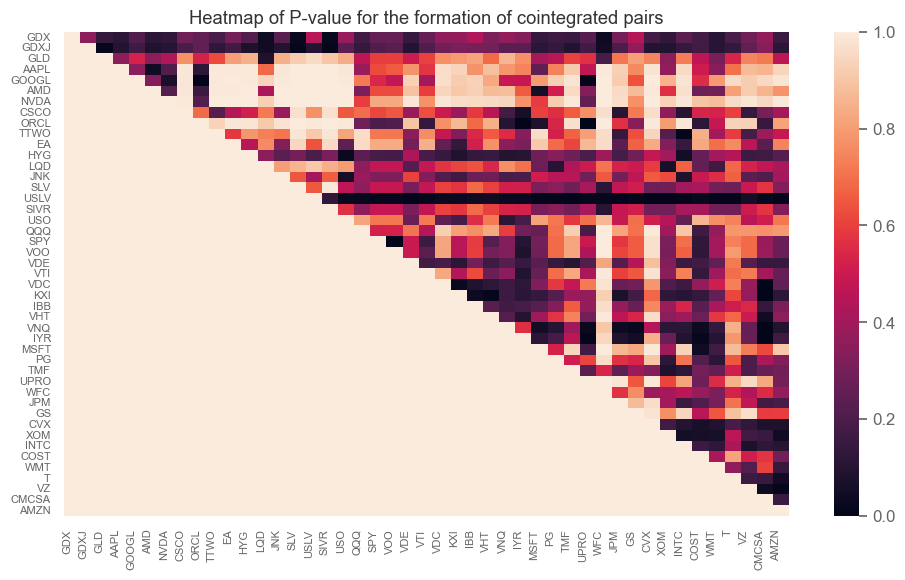

In [58]:
# Use Seaborn to plot a heatmap of our results matrix
sns.heatmap(pvalue_matrix_df, xticklabels=binance_symbols,yticklabels=binance_symbols)
plt.title('Heatmap of P-value for the formation of cointegrated pairs')

plt.xticks(ha='right', size=8)
plt.yticks(size=8)
plt.tight_layout()
plt.show();

In [37]:
for pair in pairs:
    print("Asset {} and Asset {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))

Asset GDX and Asset LQD has a co-integration score of 0.0385
Asset GDX and Asset SLV has a co-integration score of 0.0286
Asset GDX and Asset SIVR has a co-integration score of 0.0216
Asset GDX and Asset WFC has a co-integration score of 0.0316
Asset GDXJ and Asset GLD has a co-integration score of 0.0135
Asset GDXJ and Asset LQD has a co-integration score of 0.0468
Asset GDXJ and Asset SLV has a co-integration score of 0.0145
Asset GDXJ and Asset SIVR has a co-integration score of 0.0154
Asset GDXJ and Asset WFC has a co-integration score of 0.0443
Asset AAPL and Asset AMD has a co-integration score of 0.0462
Asset GOOGL and Asset ORCL has a co-integration score of 0.001
Asset GOOGL and Asset UPRO has a co-integration score of 0.0061
Asset ORCL and Asset IYR has a co-integration score of 0.0061
Asset ORCL and Asset UPRO has a co-integration score of 0.0013
Asset TTWO and Asset INTC has a co-integration score of 0.0142
Asset HYG and Asset USO has a co-integration score of 0.0276
Asset 

In [38]:
len(pairs)

66

In [39]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
  # Aligning the results with the original time series index
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

In [40]:
def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices (df)
    # s1: the symbol of asset one
    # s2: the symbol of asset two
    # x: the price series of asset one
    # y: the price series of asset two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate
    
    x = df[s1]
    y = df[s2]
    
    # Run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = abs(state_means[:,0])   # Hedge Ratio
    df1['spread'] = df1.y - (df1.x * df1.hr)    # Spread: Price difference = y - B*x
    
    # calculate half life
    halflife = half_life(df1['spread'])
    
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    
    ##############################################################
    
    # trading logic
    entryZscore = 1.25
    exitZscore = -0.08
    
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    #set up totals: num units and returns
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################
    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
        
    ##############################################################
    
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = (end_val / start_val) ** (252.0/days) - 1
    
    df1[s1+ " "+s2+'_cum_rets'] = df1['cum rets']

    
    return df1[s1+ " "+s2+'_cum_rets'], sharpe, CAGR

In [41]:
results = []
for pair in pairs:
    rets, sharpe, CAGR = backtest(df[split:],pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],
                                                                                     round(sharpe,2),
                                                                                     round(CAGR,4)))
    rets0 = pd.concat(results, axis=1)

The pair GDX and LQD produced a Sharpe Ratio of 1.24 and a CAGR of 0.0954
The pair GDX and SLV produced a Sharpe Ratio of 1.65 and a CAGR of 0.0815
The pair GDX and SIVR produced a Sharpe Ratio of 1.77 and a CAGR of 0.087
The pair GDX and WFC produced a Sharpe Ratio of 0.98 and a CAGR of 0.1027
The pair GDXJ and GLD produced a Sharpe Ratio of 1.41 and a CAGR of 0.0938
The pair GDXJ and LQD produced a Sharpe Ratio of 0.95 and a CAGR of 0.086
The pair GDXJ and SLV produced a Sharpe Ratio of 2.6 and a CAGR of 0.1234
The pair GDXJ and SIVR produced a Sharpe Ratio of 2.64 and a CAGR of 0.1253
The pair GDXJ and WFC produced a Sharpe Ratio of 0.35 and a CAGR of 0.0414
The pair AAPL and AMD produced a Sharpe Ratio of 1.47 and a CAGR of 0.1409
The pair GOOGL and ORCL produced a Sharpe Ratio of 1.38 and a CAGR of 0.1041
The pair GOOGL and UPRO produced a Sharpe Ratio of 1.05 and a CAGR of 0.0911
The pair ORCL and IYR produced a Sharpe Ratio of 1.57 and a CAGR of 0.1061
The pair ORCL and UPRO pro

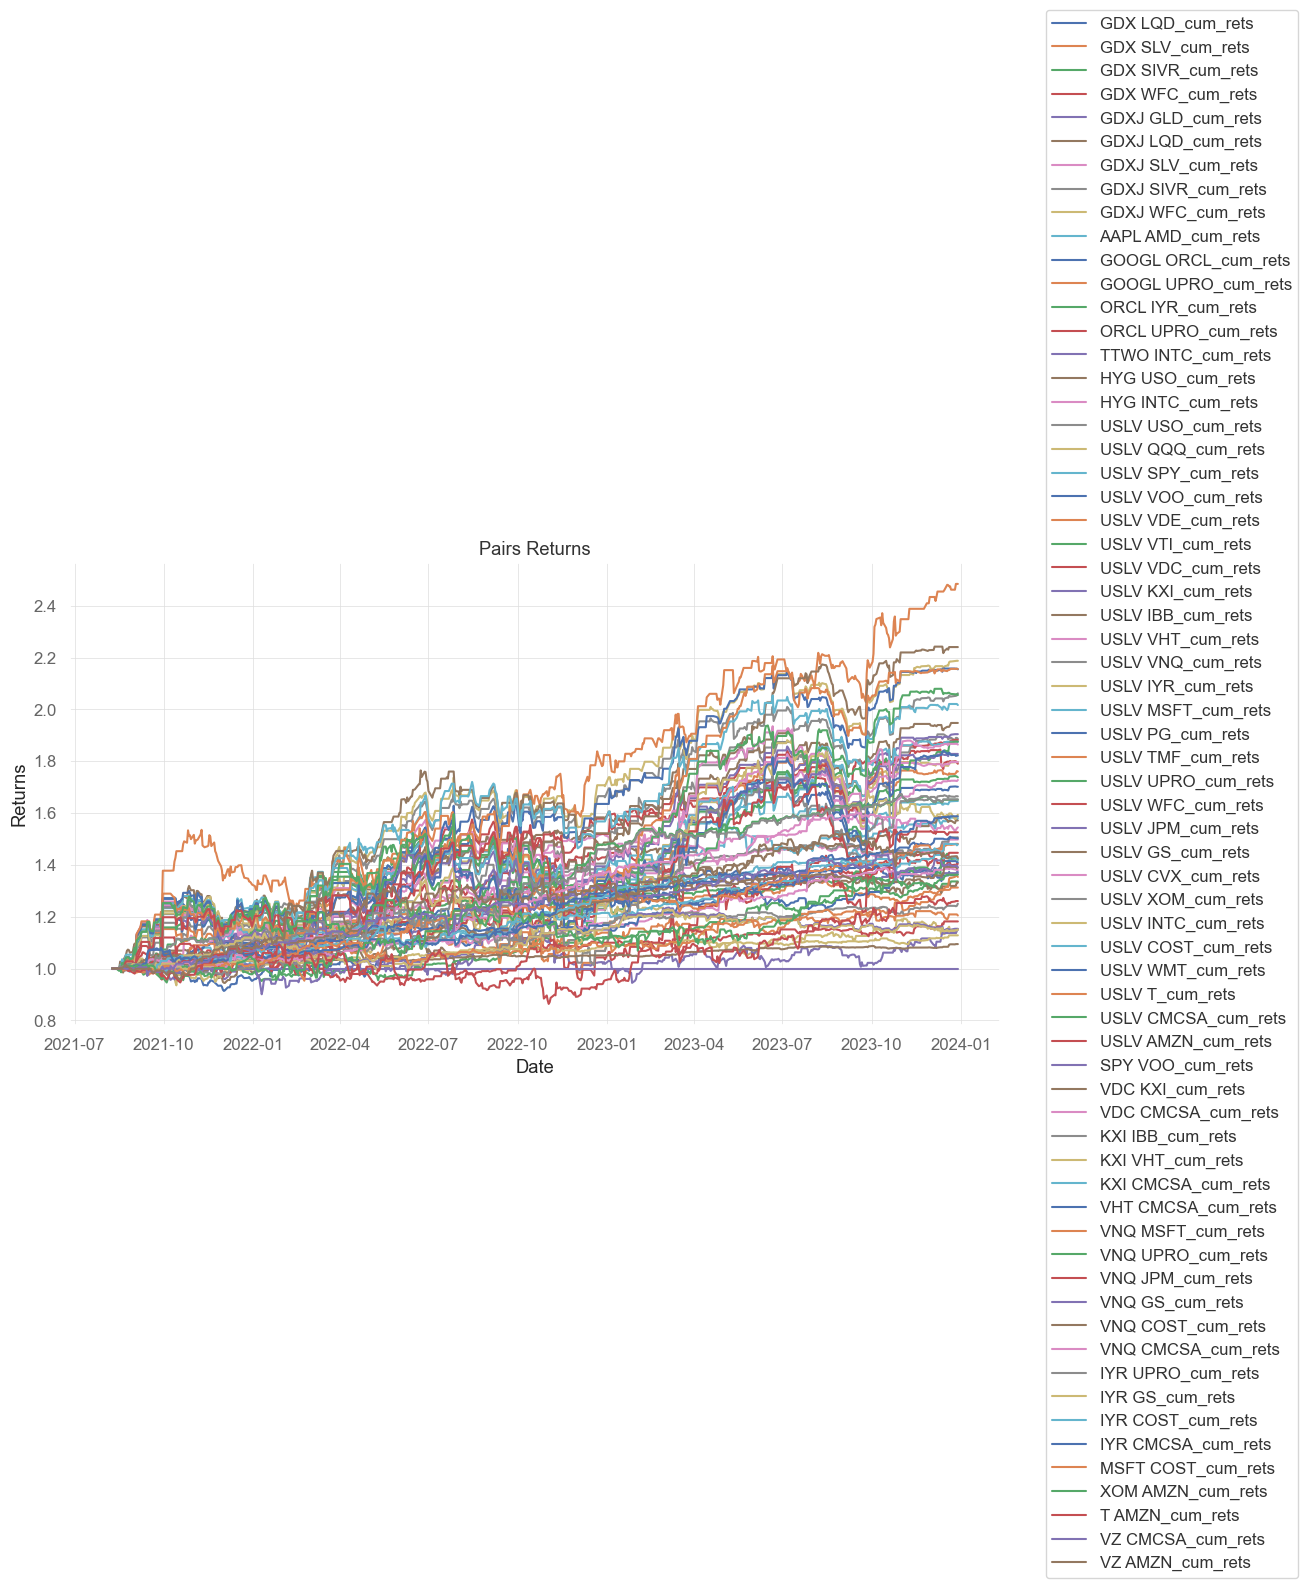

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(rets0)
plt.legend(rets0.columns, bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()


# Total Returns Performance

In [43]:
#concatenate together the individual equity curves into a single DataFrame
results_df = pd.concat(results,axis=1).dropna()
#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)
#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)


In [44]:
Pair_Rets = ffn.to_returns(final_res)
Pair_Rets = pd.DataFrame(Pair_Rets)
Pair_Rets = Pair_Rets.fillna(0)
Pair_Rets.columns = ['Pairs_Returns']

In [45]:
perf = final_res.calc_stats()
num_pairs = len(results_df.columns)

In [46]:
# set SPY as benchmark
bench = df.loc[str(Pair_Rets.index[0]):str(Pair_Rets.index[-1])].SPY.pct_change().dropna()
Pair_Rets0 = Pair_Rets.loc[str(bench.index[0]):str(bench.index[-1])]

In [47]:
# Calculate cumulative returns for the pair strategy and the benchmark
cumulative_returns = (1 + Pair_Rets.Pairs_Returns).cumprod()
benchmark_cumulative_returns = (1 + bench).cumprod()

# Calculate additional statistics like annual return, volatility, etc.
annual_return = Pair_Rets.Pairs_Returns.mean() * 252
annual_volatility = Pair_Rets.Pairs_Returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_volatility

benchmark_annual_return = bench.mean() * 252
benchmark_annual_volatility = bench.std() * np.sqrt(252)
benchmark_sharpe_ratio = benchmark_annual_return / benchmark_annual_volatility

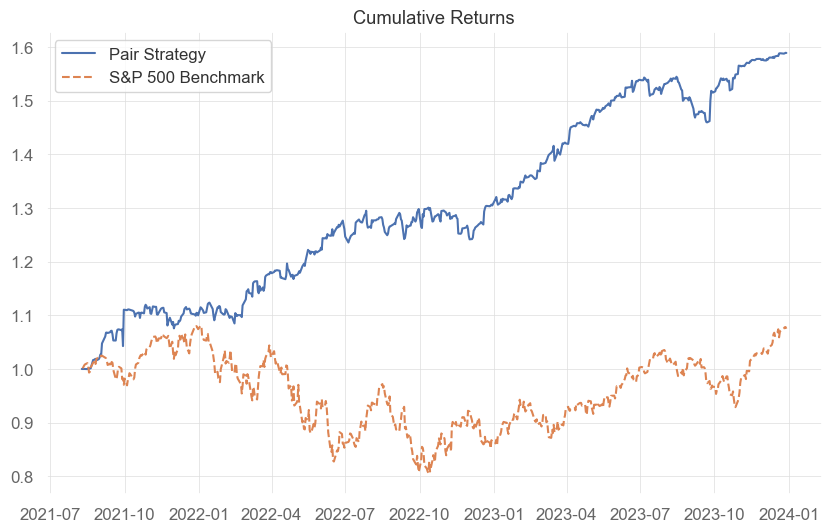

In [48]:
# Cumulative Returns
plt.plot(cumulative_returns, label='Pair Strategy')
plt.plot(benchmark_cumulative_returns, label='S&P 500 Benchmark', linestyle='--')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

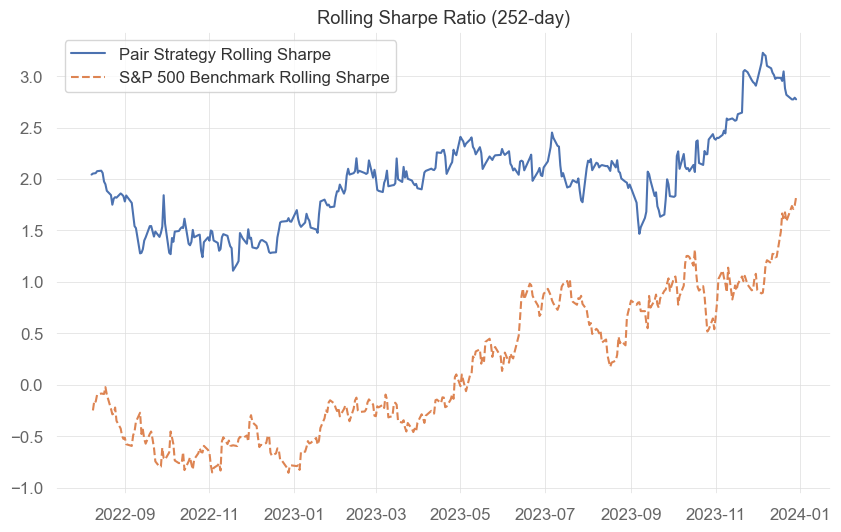

In [49]:
# Rolling Sharpe Ratio (assuming a rolling window of 252 days)
rolling_sharpe_strategy = (Pair_Rets.Pairs_Returns.rolling(window=252).mean() * 252) / (Pair_Rets.Pairs_Returns.rolling(window=252).std() * np.sqrt(252))
rolling_sharpe_benchmark = (bench.rolling(window=252).mean() * 252) / (bench.rolling(window=252).std() * np.sqrt(252))

plt.plot(rolling_sharpe_strategy, label='Pair Strategy Rolling Sharpe')
plt.plot(rolling_sharpe_benchmark, label='S&P 500 Benchmark Rolling Sharpe', linestyle='--')
plt.title('Rolling Sharpe Ratio (252-day)')
plt.legend()
plt.show()

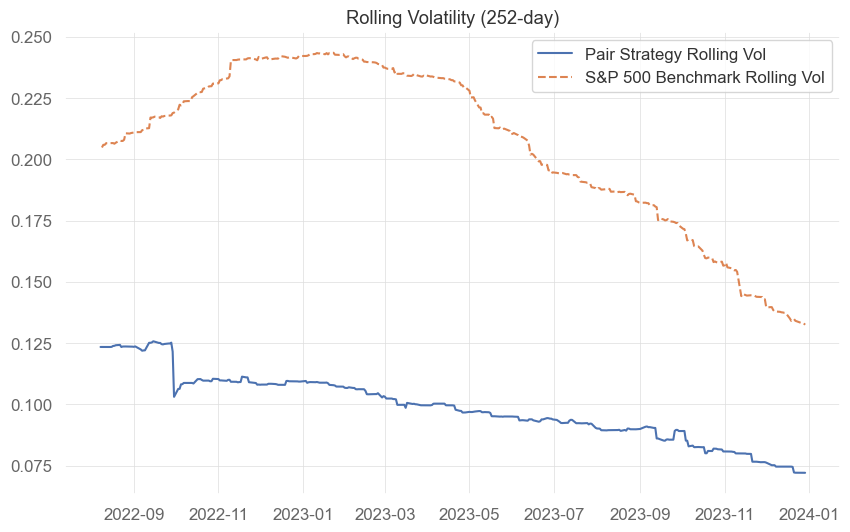

In [50]:
# Rolling Volatility (assuming a rolling window of 252 days)
rolling_volatility_strategy = Pair_Rets.Pairs_Returns.rolling(window=252).std() * np.sqrt(252)
rolling_volatility_benchmark = bench.rolling(window=252).std() * np.sqrt(252)

plt.plot(rolling_volatility_strategy, label='Pair Strategy Rolling Vol')
plt.plot(rolling_volatility_benchmark, label='S&P 500 Benchmark Rolling Vol', linestyle='--')
plt.title('Rolling Volatility (252-day)')
plt.legend()
plt.show()

In [51]:
# Print out the statistics
print(f"Pair Strategy Annual Return: {annual_return:.2%}")
print(f"Pair Strategy Annual Volatility: {annual_volatility:.2%}")
print(f"Pair Strategy Sharpe Ratio: {sharpe_ratio:.2f}")
print('')
print(f"Benchmark Annual Return: {benchmark_annual_return:.2%}")
print(f"Benchmark Annual Volatility: {benchmark_annual_volatility:.2%}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

Pair Strategy Annual Return: 19.89%
Pair Strategy Annual Volatility: 10.29%
Pair Strategy Sharpe Ratio: 1.93

Benchmark Annual Return: 4.77%
Benchmark Annual Volatility: 18.65%
Benchmark Sharpe Ratio: 0.26
